In [36]:
import pandas as pd
import requests
import re
import random
from random import sample
import json
import math
from utils import *
from sentence_classifier import SentenceClassifier
from tokenizer_class import TokenizerClass
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import csv
import keras
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

In [6]:

all_articles = pd.read_csv("all_protected_wiki_list.csv")
articles=list(all_articles['title'])

In [9]:
article_texts=[]

for name in articles:
    raw=fetch_rawtext_from_wiki(name)
    article_texts.append(raw)
all_articles['full_text']=article_texts



In [2]:
all_articles=pd.read_csv('fulltext_wiki_protected.csv',sep=',')[['title','bytes','full_text']]

In [39]:
print(all_articles)

                              title   bytes  \
0                        Rudolf Heß   86509   
1                              Popo     805   
2                            Kanake     309   
3                             Bitch    5369   
4                           Fisting    7432   
...                             ...     ...   
2840  Marie-Agnes Strack-Zimmermann   28388   
2841                     Mike Tyson   83016   
2842                       Toilette   51005   
2843                    Braunwasser    1238   
2844                   Zirkumzision  223530   

                                              full_text  
0     Rudolf Walter Richard Heß [hɛs] (* 26. April 1...  
1                              Popo ist \nSiehe auch:\n  
2                    Kanake steht für:\n\nSiehe auch:\n  
3     Bitch  ist ein Begriff aus dem Englischen, der...  
4     Faustverkehr (engl. Fisting, von fist „Faust“)...  
...                                                 ...  
2840  Marie-Agnes Strack-Zimm

In [3]:
i=1
df=preprocess_classify_wiki_text(all_articles['full_text'].iloc[0])
while i<len(all_articles):
    working_df=preprocess_classify_wiki_text(all_articles['full_text'].iloc[i])
    df=pd.concat([df,working_df])
    i+=1

In [11]:
all_articles.to_csv('fulltext_wiki_protected.csv')

In [6]:
df=df[['text','target']]

In [2]:
df=pd.read_csv('all_sentences_protected_wiki.csv')

In [19]:
df=pd.DataFrame()

In [4]:
df_train = df.sample(1000)

In [4]:
# Loop over articles

text=''
for name in articles:
    raw=fetch_rawtext_from_wiki(name)
    text=text + raw
df=preprocess_classify_wiki_text(text)
df.to_csv('all_wiki_full.csv')



KeyboardInterrupt: 

In [18]:
print(df_train)

      Unnamed: 0.1  Unnamed: 0                        title   bytes  \
1303          1303        1303         Antikes Griechenland  121002   
749            749         749                Gerhard Hasse    6171   
70              70          70                  August Fick    3895   
137            137         137                     Skinhead   35205   
1911          1911        1911                 John Maynard   10778   
...            ...         ...                          ...     ...   
1763          1763        1763               Galaktoboureko    1143   
1745          1745        1745                One Direction   12357   
1414          1414        1414    Wirtschaft im Mittelalter    6407   
1269          1269        1269               Wladimir Putin      49   
275            275         275  Missbrauch und Abhängigkeit      42   

                                              full_text  
1303  Das antike Griechenland hat die Entwicklung de...  
749   Gerhard Friedrich Hasse (

In [65]:
model = keras.models.Sequential()
model.add(layers.Embedding(claim_extract.tokenizer_class.num_unique_words, 32, input_length=32))
# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.
model.add(layers.LSTM(256, dropout=0.1))
model.add(layers.Dense(1, activation="relu"))
#TODO try out others than sigmoid
#min 2nd layer or more
model.summary()
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["accuracy"]
model.compile(loss=loss, optimizer=optim, metrics=metrics)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 32, 32)            3047008   
                                                                 
 lstm_21 (LSTM)              (None, 256)               295936    
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,343,201
Trainable params: 3,343,201
Non-trainable params: 0
_________________________________________________________________


In [66]:
df_train=df.sample(50000,random_state=2)
tokenizer=TokenizerClass()
claim_extract=SentenceClassifier(tokenizer_class=tokenizer,model=model)
claim_extract.preprocess_train_val(df_train)
claim_extract.train_model()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 32, 32)            3047008   
                                                                 
 lstm_21 (LSTM)              (None, 256)               295936    
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 3,343,201
Trainable params: 3,343,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
668/668 [==============================] - 35s 51ms/step - loss: 0.7804 - accuracy: 0.4962 - val_loss: 0.6675 - val_accuracy: 0.5973
Epoch 2/20
668/668 [==============================] - 33s 50ms/step - loss: 0.6485 - accuracy: 0.6337 - val_loss: 0.6550 - val_accuracy: 0.6234
Epoch 3/20
668/668 

In [69]:
annotated=pd.read_csv('FullAnnotated1.csv',sep=';',dtype={'sentence':'str'})
annotated=annotated[annotated['to_exclude']==0]
annotated['prediction']=claim_extract.predict_target(annotated['sentence'])

4/4 [==============================] - 0s 14ms/step


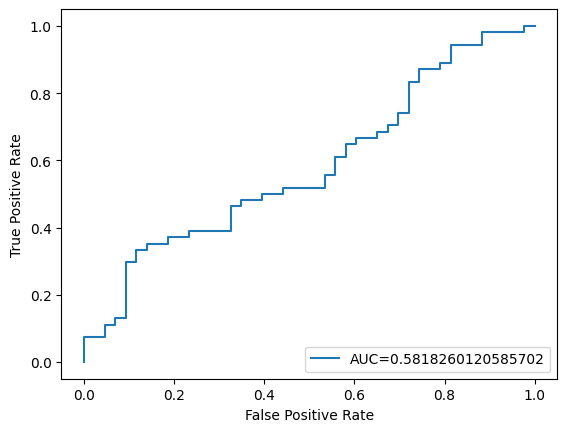

In [70]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(annotated['is_claim'],  annotated['prediction'])
auc = metrics.roc_auc_score(annotated['is_claim'],  annotated['prediction'])
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [9]:
raise KeyboardInterrupt("Until autorun till here!")

KeyboardInterrupt: Until autorun till here!

In [ ]:
print(annotated)

     Unnamed: 0                                           sentence  is_claim  \
0             0  Ärger über Gasmasken-Eklat Samstag, 1 Juli, 12...         1   
1             1  Dabei hatte die Projektleitung eigentlich ein ...         0   
2             2  Trotz der beiden Bike-Lanes ist der Verkehr au...         1   
3             3  Interessant ist, dass es der Civey-Umfrage zuf...         1   
4             4  Die Salzburger Festspiele aber haben sich zumi...         0   
..          ...                                                ...       ...   
100         100  Auf manchen Friedhöfen gebe es eine überdachte...         0   
101         101  Sie schlagen mit ihren Gummiknüppeln auf die M...         1   
102         102  Anfang Mai wähnte sich die nationalpopulistisc...         1   
104         104  Der Inhalt der Mails, die dem britischen Morni...         1   
105         105                           ZEIT ONLINE: Inwiefern\?         0   

     to_exclude      prediction  
0    

4/4 [==============================] - 0s 3ms/step


In [ ]:
fang_text=fetch_from_fangcovid_local(5,10)
#fang_pre=preprocess_text(fang_text)
df_fang=pd.DataFrame()
df_fang["text"]=split_text(fang_text)
df_fang["prediction"]=claim_extract.predict_target(df_fang["text"])

# df_fang["tokenized"]=tokenizer.texts_to_sequences(df_fang["sentence"])
# fang_padded = pad_sequences(df_fang["tokenized"], maxlen=32, padding="post", truncating="post")
# df_fang["predictions"]=model.predict(fang_padded)

In [ ]:
articles = articles+articles_strict

In [12]:
articles_strict=['Wiesentalbrücke','Mammut (Gattung)','Riemannsche Vermutung','Reichstag zu Augsburg','Deutsch-Französischer Krieg','Kantonsspital Winterthur','Femizid','Nicht-zufällige Segregation von Chromosomen','Beryllium','Massenaussterben','Covid-19','Pandemie','Sex','Homosexualität','OG Keemo','Conchita Wurst','Hochschule für Medien, Kommunikation und Wirtschaft','Europäische Union','Biographie','Donald Trump','Angstzustände','Doktortitel','BAHN-BKK']
articles=articles+articles_strict

In [11]:
articles=["Maschinelles Lernen", "Medizin","Wissenschaft","Krankheit","Prävention","Diagnose","Politik","COVID-19","COVID-19-Pandemie","Epidemie","Mykose","Sexuell übertragbare Erkrankung","Infektionskrankheit","Bundestag","Bundesrat","Zeitung","Rundfunk","Verlag","Politisches System der Bundesrepublik Deutschland","Politisches System","Massenmedien","Medienwissenschaft","Publikation"]


In [ ]:
# Loop over articles

text=''
for name in articles:
    print(name)
    raw=fetch_rawtext_from_wiki(name)
    text=text + raw
df=preprocess_classify_wiki_text(text)



Wiesentalbrücke
Mammut (Gattung)
Riemannsche Vermutung
Reichstag zu Augsburg
Deutsch-Französischer Krieg
Kantonsspital Winterthur
Femizid
Nicht-zufällige Segregation von Chromosomen
Beryllium
Massenaussterben
Covid-19
Pandemie
Sex
Homosexualität
OG Keemo
Conchita Wurst
Hochschule für Medien, Kommunikation und Wirtschaft
Europäische Union
Biographie
Donald Trump
Angstzustände
Doktortitel
BAHN-BKK


In [ ]:
#Pipeline, if "claims" is free text of all labeled claims 

split_claims=split_text(claims)
df_claim =pd.DataFrame()
df_claim["text"]= split_claims
df_claim=df_claim.assign(target=True)
df=df.loc[df["target"]==False]
df=pd.concat([df,df_claim])

In [ ]:
## Re-Balanced Class Sets
df_majority = df[df.target==0]
df_minority = df[df.target==1]
 
# Downsample majority class
df_majority_downsampled = random.sample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2451,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])

NameError: name 'resample' is not defined

In [ ]:
fang_text=fetch_from_fangcovid_local(5,10)
#fang_pre=preprocess_text(fang_text)
df_fang=pd.DataFrame()
df_fang["sentence"]=split_text(fang_text)
df_fang["tokenized"]=tokenizer.texts_to_sequences(df_fang["sentence"])
fang_padded = pad_sequences(df_fang["tokenized"], maxlen=32, padding="post", truncating="post")
df_fang["predictions"]=model.predict(fang_padded)

In [ ]:
# df_fang["predictions"]=model.predict(fang_padded)

print(df_fang.sort_values("predictions"))
os.chdir("/Users/jannis/Desktop/fang-covid-main")
df_fang=df_fang[['predictions','sentence']]
df_fang.to_csv("results7.csv" )

In [ ]:
label_count={}
claims=" "
os.chdir("/Users/jannis/Desktop/x-fact-main/data/x-fact")
with open("train.all.tsv", 'r') as fp:
    for line in fp:
        arr = line.strip().split('\t')
        lang = arr[1].lower()
        site = arr[2].lower()
        domain = (lang, site)
        

        if domain not in label_count:
                label_count[domain] = {}
        if arr[0] == 'de':
            claims = claims + arr[3]
            print(arr[3])
            

        label = arr[-1].lower()

        if label not in label_count[domain]:
            label_count[domain][label] = 0
        label_count[domain][label] +=1



# new_map = {}
# for key in label_count.keys():
#     new_map[key] = {}
#     counts = label_count[key]

#     total = 0
#     for k, v in counts.items():
#         total += v

#     for k,v in counts.items():
#         new_map[key][k] = float(v)/total


# print(new_map)

# total = 0
# count = 0
# for key in new_map.keys():
#     counts = new_map[key]
#     take = True
#     for k, v in counts.items():
#         if v > 0.7:
#             take = False

#     if take:
#         print(key)
#         count +=1
#         for k, v in label_count[key].items():
#             total += v

# print(total)
# print(count)


In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/justusmattern/fang-covid/main/articles/20000.json")


In [ ]:
from datasets import load_dataset
dataset = load_dataset("mlsum", "de")
df_json=pd.read_json(dataset["train"])
claim=" "
i=0
while i<10000:
    claim=claim+dataset["train"]["summary"][randint(0,220000)]
    i=+1
array=dataset["train"]["summary"][:10000]
s=" ".join(array)


In [ ]:
nlp=German()
doc=nlp(text)
nlp.add_pipe('sentencizer')
sents=list(doc.sents)
print(sents)

In [ ]:
def tokenize_text(text):
    nlp = spacy.load("de_core_news_md")
    doc = nlp(sentences[0])
    print(doc.text)
    for token in doc:
        print(token.text, token.pos_, token.dep_)